In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
torch:  1.13 ; cuda:  1.13.1


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-u4qtasbc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-u4qtasbc
  Resolved https://github.com/facebookresearch/detectron2.git to commit d4a5f28e01b2babbaba9f90198fb95f5c661cccd
  Preparing metadata (setup.py) ... done


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
import os

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.engine import (
    default_argument_parser,
    default_setup,
    DefaultTrainer,
    launch,
)
from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator
from detectron2.layers import get_norm
from detectron2.modeling.roi_heads import Res5ROIHeads, ROI_HEADS_REGISTRY


In [5]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        if "coco" in dataset_name:
            return COCOEvaluator(dataset_name, cfg, True, output_folder)
        else:
            assert "voc" in dataset_name
            return PascalVOCDetectionEvaluator(dataset_name)

In [6]:
def setup():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.freeze()
    return cfg


In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [8]:
cfg=setup()

In [9]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'detectron2://ImageNetPretrained/MSRA/R-50.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1

In [10]:
model = Trainer.build_model(cfg)

[05/07 22:23:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [11]:
cfg.OUTPUT_DIR,cfg.MODEL.WEIGHTS

('./output', 'detectron2://ImageNetPretrained/MSRA/R-50.pkl')

In [12]:
model_weights="detection/best_converted.pth"
out_dir="detection_output"

In [13]:
checkpointer = DetectionCheckpointer(model)
checkpointer.load(model_weights)

[05/07 22:23:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detection/best_converted.pth ...
[05/07 22:23:50 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint                                                               | Shapes                                          |
|:------------------|:----------------------------------------------------------------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

{'__author__': 'MOCO', 'matching_heuristics': True}

In [14]:

import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
    
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [15]:
import random
dataset_dicts = get_balloon_dicts("balloon/train")

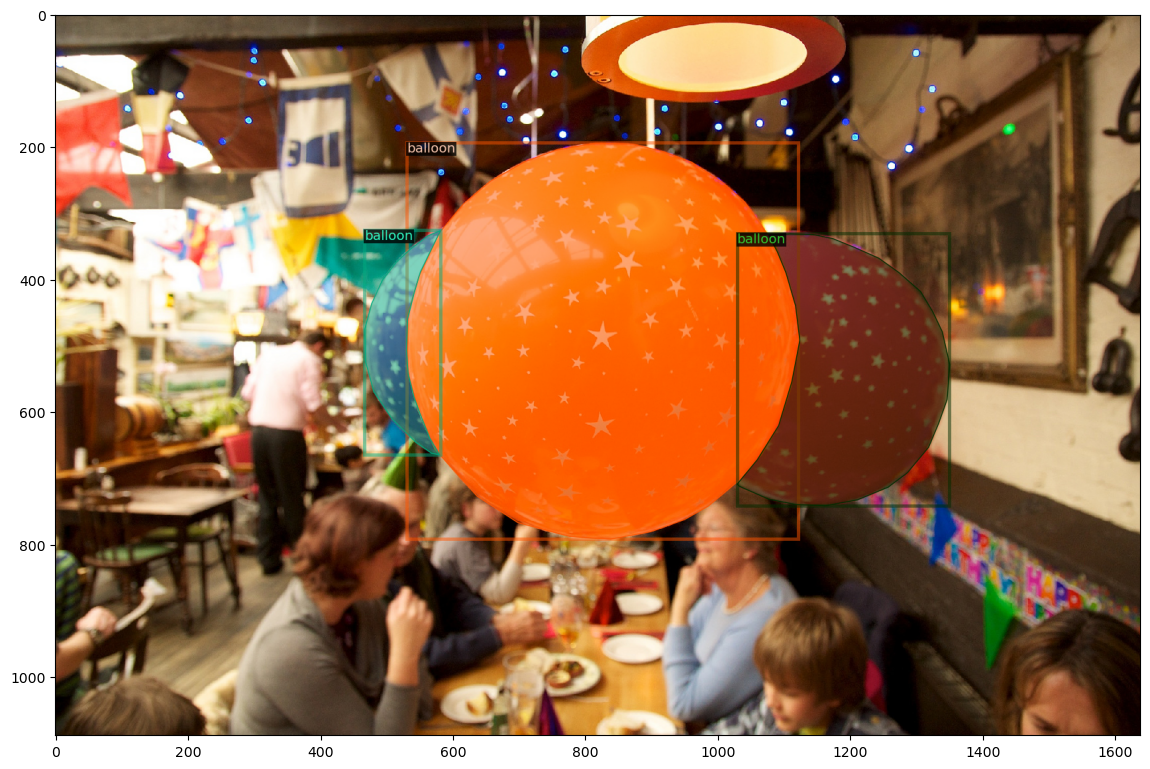

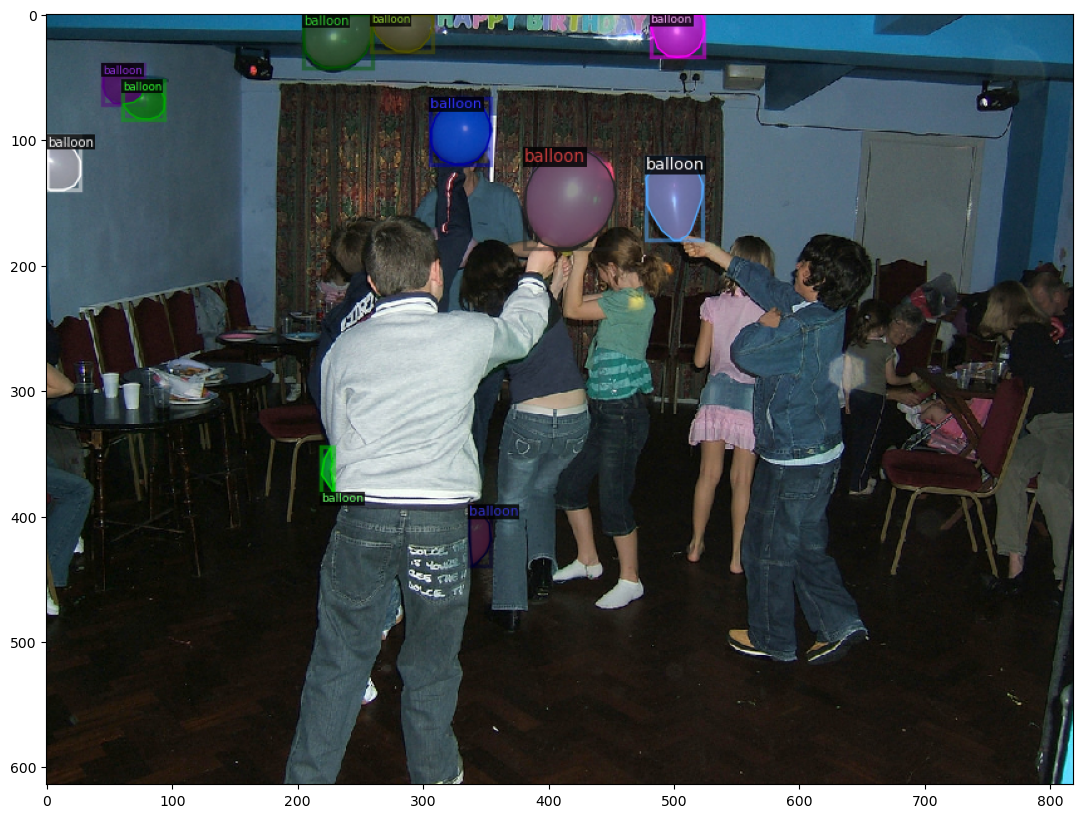

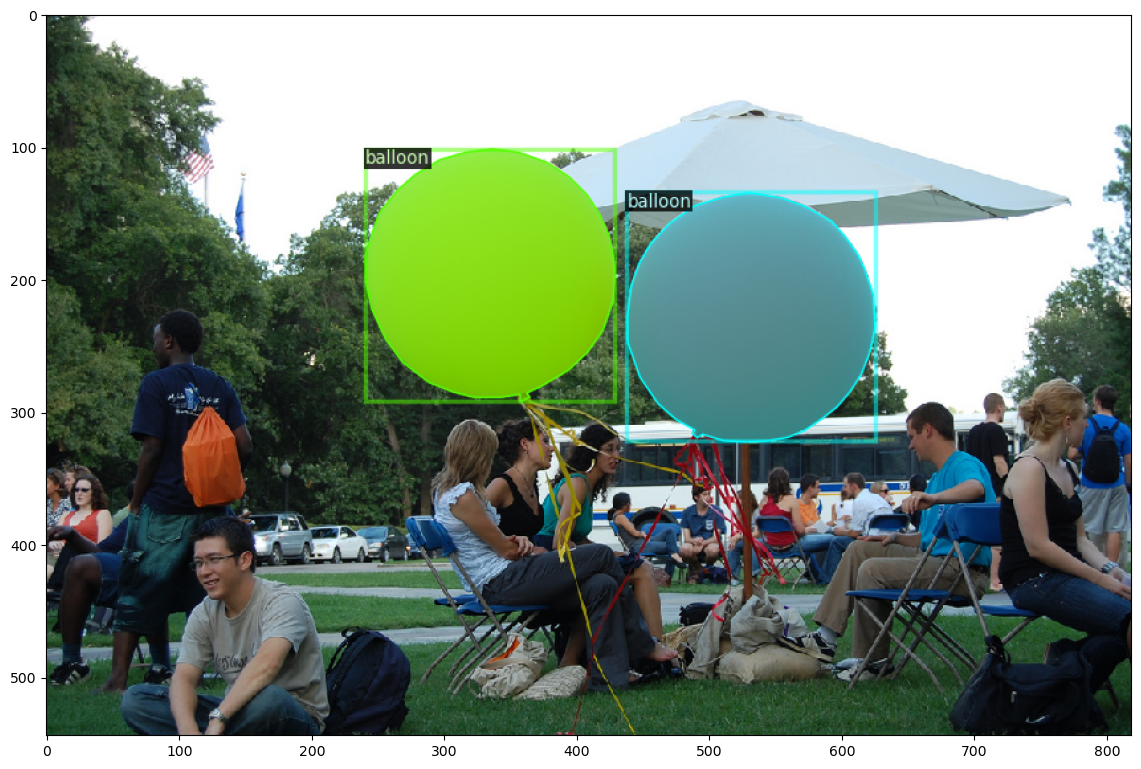

In [16]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [18]:
from detectron2.utils.analysis import  flop_count_operators
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from scipy.spatial import distance
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation import DatasetEvaluator
import detectron2.utils.logger as logger
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.data.detection_utils as mapperutils
import detectron2.data.transforms as mapperT
from detectron2.evaluation import COCOEvaluator

class LossEvalHook(HookBase):
    """Hook Class for Calculating Evaluation

    Args:
        HookBase ([type]): Hooks for training intermediate output
    """

    def __init__(self, cfg, model, data_loader):
        self.cfg=cfg
        self._period = self.cfg.TEST.EVAL_PERIOD
        self._data_loader = data_loader
        self.predictor = DefaultPredictor(cfg)
        self.predictor.model=model
        self.calculate_flops=True
        #self.cls_meta = cfg.DATASETS.METADATAINFO
        assert id(self.predictor.model)==id(model)

    def _do_loss_eval(self):
        losses = []
        with torch.no_grad():
            for idx, inputs in enumerate(self._data_loader):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                loss_batch = self._get_loss(inputs)
                losses.append(loss_batch)
            mean_loss = np.mean(losses)
            logger.logging.info(f"Mean Validation loss {mean_loss}")
            self.trainer.storage.put_scalar("Validation_Loss", mean_loss)
            comm.synchronize()
        return losses
    
    
    def vis_images(self,num_images=20):
        # set model to eval
        self.predictor.model.eval()
        log_counter = 0
        for idx, inputs in enumerate(self._data_loader):
            img=inputs[0]["image"].permute(1,2,0).detach().to("cpu").numpy()
            img=img.copy()
            outputs = self.predictor(img) 
            v = Visualizer(img[:, :, ::-1],
                            metadata=None, 
                            scale=0.5, 
                            instance_mode=ColorMode.IMAGE_BW   
                )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            log_counter += 1
            #out.get_image()
            if idx>=num_images:
                break
        #set back to train
        self.predictor.model.train()
        

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self.predictor.model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
    
    def get_flops(self):
        # Take one batch
        inputs= next(iter(self._data_loader))
        flops=flop_count_operators(self.predictor.model,inputs)
        return flops
    
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if self.calculate_flops:
            flps=self.get_flops()
            total=0
            for k,v in flps.items():
                total+=v
            # total has flops
            self.calculate_flops=False
            
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
            logger.logging.info(f"Validation Bbox AP {self.trainer.storage.history('bbox/AP').latest()}")
            logger.logging.info(f"Validation Segmentation AP {self.trainer.storage.history('segm/AP').latest()}")
            self.vis_images()



class LossTrainHook(HookBase):
    """Hook Class for Calculating Evaluation

    Args:
        HookBase ([type]): Hooks for training intermediate output
    """

    def __init__(self,period):
        self._period=period

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            train_loss=self.trainer.storage.history("total_loss").median(20)
            #if self.wab:
            #    self.wab.log({"Train Loss": train_loss})


class InstanceTrainer(DefaultTrainer):
    """Create a trainer for veg datasets

    Args:
        DefaultTrainer ([type]): Default trainer from detectron2

    Returns:
        [type]: [description]
    """
    def __init__(self,cfg):
        super().__init__(cfg)
        
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name,output_dir=cfg.OUTPUT_DIR)

    def build_hooks(self):
        hooks = super().build_hooks()
        # Build mapper Augmentations by passing the test mode but pass the test mode=False in mapper to get the labels finally replace the augm list with the 
        #  test one a workaround to not change the mapper class 
        augs=mapperutils.build_augmentation(self.cfg, is_train=False)
        augsList=mapperT.AugmentationList(augs)
        val_mapper=DatasetMapper(self.cfg, True)
        val_mapper.augmentations=augsList
          
        hooks.insert(
            -1,
            LossEvalHook(
                self.cfg,
                self.model,
                build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0], val_mapper),
            ),
        )
        hooks.insert(
            -1,
            LossTrainHook(self.cfg.TRAINLOG)
        )
        return hooks

In [19]:
import yaml
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ("balloon_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_weights
# cfg["INPUT"]["MASK_FORMAT"]='bitmask'
cfg["INPUT"]["RANDOM_FLIP"] = "horizontal"
cfg["INPUT"]["ROTATE"] = [-2.0, 2.0]
cfg["INPUT"]["LIGHT_SCALE"] = 1.1
cfg["INPUT"]["Brightness_SCALE"] = [0.9, 1.1]
cfg["INPUT"]["Contrast_SCALE"] = [0.9, 1.1]
cfg["INPUT"]["Saturation_SCALE"] = [0.9, 1.1]
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-4  # pick a good LR
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.SOLVER.MAX_ITER = 10000  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.TEST.EVAL_PERIOD=1000
cfg.OUTPUT_DIR=out_dir
os.makedirs(cfg.OUTPUT_DIR ,exist_ok=True)
# New configs
cfg.set_new_allowed(True)
cfg.TRAINLOG=100
cfg_dict=yaml.load(cfg.dump())
# save all the configs for prediction
with open(os.path.join(cfg.OUTPUT_DIR,"pred_config.yaml"), 'w') as file:
    file.write(cfg.dump())

/tmp/ipykernel_26447/2531236509.py:29: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_dict=yaml.load(cfg.dump())


In [ ]:
trainer = InstanceTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/07 22:24:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/07 22:24:37 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[05/07 22:24:37 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 255          |
|            |              |
[05/07 22:24:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/07 22:24:37 d2.data.build]: Using training sampler TrainingSampler
[05/07 22:24:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/07 22:24:37 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[05/07 22:24:37 d2.data.common]: Serialized dataset takes 0.17 MiB
WARNING [05/07 22:24:37 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[05

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[05/07 22:24:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detection/best_converted.pth ...
[05/07 22:24:41 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint                                                               | Shapes                                          |
|:------------------|:----------------------------------------------------------------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[05/07 22:24:41 d2.engine.train_loop]: Starting training from iteration 0


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Unsupported operator prim::CallFunction encountered 24 time(s)
Unsupported operator aten::pad encountered 1 time(s)
Unsupported operator aten::topk encountered 5 time(s)
Unsupported operator torchvision::roi_align encountered 8 time(s)


[05/07 22:24:48 d2.utils.events]:  eta: 0:30:39  iter: 19  total_loss: 78  loss_cls: 21.71  loss_box_reg: 8.889  loss_mask: 3.08  loss_rpn_cls: 10.21  loss_rpn_loc: 7.283    time: 0.1871  last_time: 0.2452  data_time: 0.0165  last_data_time: 0.0153   lr: 1.9981e-06  max_mem: 2722M
[05/07 22:24:52 d2.utils.events]:  eta: 0:33:34  iter: 39  total_loss: 9.735  loss_cls: 3.727  loss_box_reg: 1.067  loss_mask: 1.537  loss_rpn_cls: 1.399  loss_rpn_loc: 2.352    time: 0.2003  last_time: 0.2562  data_time: 0.0057  last_data_time: 0.0047   lr: 3.9961e-06  max_mem: 2722M
[05/07 22:24:57 d2.utils.events]:  eta: 0:35:20  iter: 59  total_loss: 4.539  loss_cls: 0.7538  loss_box_reg: 0.1599  loss_mask: 1.13  loss_rpn_cls: 0.5631  loss_rpn_loc: 1.207    time: 0.2134  last_time: 0.1973  data_time: 0.0048  last_data_time: 0.0047   lr: 5.9941e-06  max_mem: 2722M
[05/07 22:25:01 d2.utils.events]:  eta: 0:36:22  iter: 79  total_loss: 3.007  loss_cls: 0.4425  loss_box_reg: 0.0893  loss_mask: 0.9162  loss_rp

In [ ]:
# Inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ('balloon_val', )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()